In [384]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [385]:
def f(x):
    return 3*x**2 - 4*x + 5

In [386]:
f(3.0)

20.0

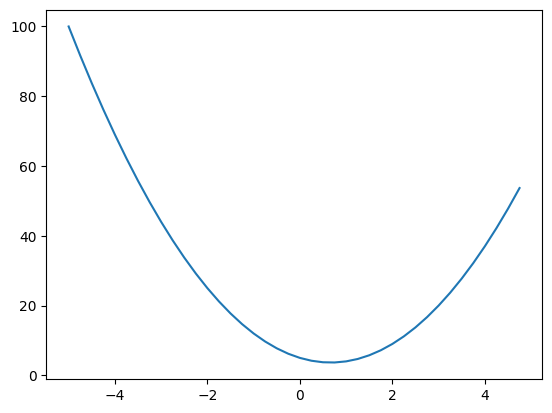

In [387]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [388]:
h = 0.001
x = -3.0
(f(x + h) - f(x)) / h  # slope (derivative) at x

-21.996999999998934

In [389]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [390]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.0009999999999994
slope 0.9999999999994458


In [391]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._children = list(_children)
        self._op = _op
        if label:  # is labelled?
            self.label = label
        elif len(_children) == 1:  # is unary op?
            self.label = f'{_op}({_children[0].label})'
        elif len(_children) == 2:  # is binary op?
            self.label = f'{_children[0].label} {_op} {_children[1].label}'
        else:  # is leaf?
            self.label = f"{data:.4f}"

    def __repr__(self):
        if self.label:
            return f"Value(label={self.label}, data={self.data:.4f})"
        else:
            return f"Value(data={self.data:.4f})"

    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
        # t = math.tanh(x)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += out.grad * (1 - out.data**2)
        out._backward = _backward

        return out

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward

        return out

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward

        return out

    def __radd__(self, other):
        return Value(other) + self

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')

        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * (-1.0)
        out._backward = _backward

        return out

    def __rsub__(self, other):
        return Value(other) - self

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return Value(other) * self

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self, other), '/')

        def _backward():
            self.grad += out.grad * (1 / other.data)
            other.grad += out.grad * (-self.data / other.data**2)
        out._backward = _backward

        return out

    def __rtruediv__(self, other):
        return Value(other) / self

    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data**other.data, (self, other), '**')

        def _backward():
            self.grad += out.grad * (other.data / self.data * out.data)
            other.grad += out.grad * (math.log(self.data) * out.data)
        out._backward = _backward

        return out

    def __rpow__(self, other):
        return Value(other) ** self

    def __neg__(self):
        out = Value(-self.data, (self,), '-')

        def _backward():
            self.grad += out.grad * (-1.0)
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(root):
            if root not in visited:
                visited.add(root)
                for child in root._children:
                    build_topo(child)
                topo.append(root)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def zero_grad(self):
        visited = set()
        def _zero_grad(root):
            if root not in visited:
                visited.add(root)
                root.grad = 0.0
                for child in root._children:
                    _zero_grad(child)
        _zero_grad(self)

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b; d.label = 'd'
e = d + c; e.label = 'e'
f = Value(-2.0, label='f')
L = e * f; L.label = 'L'

print(L._children)
print(L._op)
print(L)

[Value(label=e, data=4.0000), Value(label=f, data=-2.0000)]
*
Value(label=L, data=-8.0000)


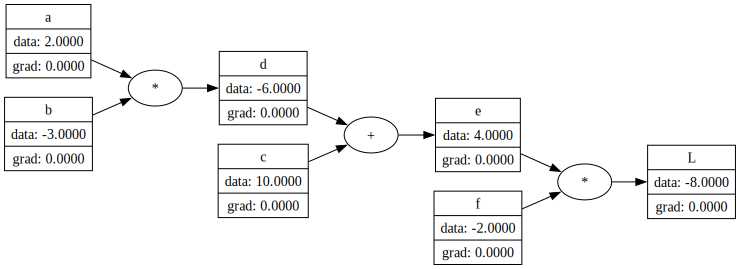

In [392]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = list(), set()
    def build(_root):
        if _root not in nodes:
            nodes.append(_root)
            for child in _root._children:
                edges.add((child, _root))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(uid, f"{n.label} | data: {n.data:.4f} | grad: {n.grad:.4f}", shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(uid + n._op, n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(L)

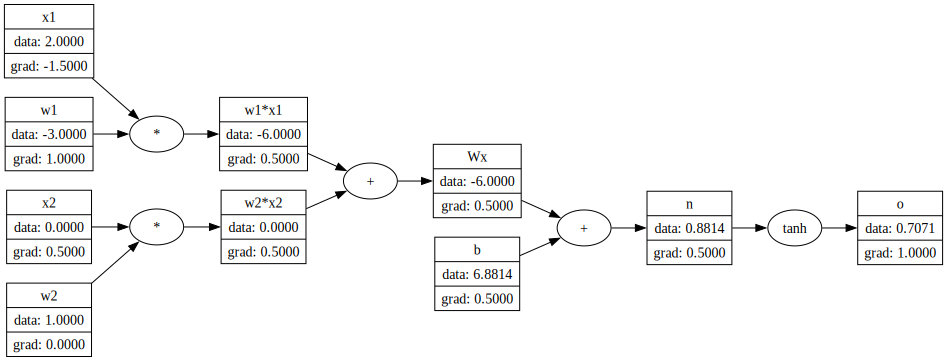

In [393]:
# Single neuron example

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1. label = 'w1*x1'
x2w2 = x2*w2; x2w2.label = 'w2*x2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'Wx'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.grad = 1.0  # initialize "loss" to backpropagate

o._backward()           # propagate through "o" = tanh("n")

n._backward()           # propagate through "n" = "Wx" + "b"

b._backward()           # propagate through "b" (leaf - nothing happens)
x1w1x2w2._backward()    # propagate through "Wx" = "w2*x2" + "w1*x1"

x2w2._backward()        # propagate through "w2*x2" = "w2" * "x2"
x1w1._backward()        # propagate through "w1*x1" = "w1" * "x1"

draw_dot(o)

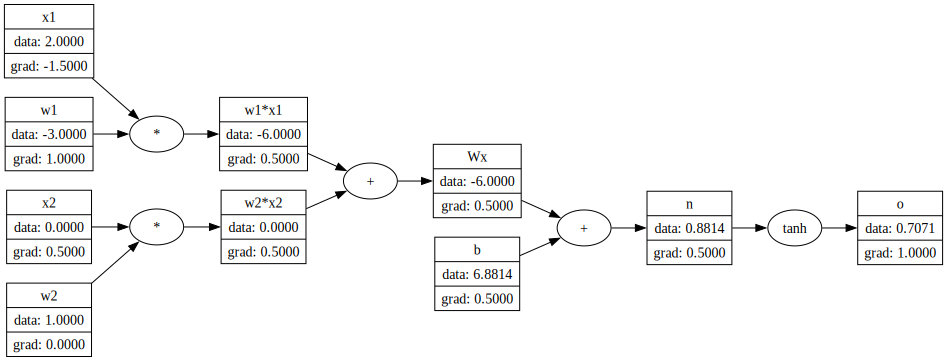

In [394]:
# let's do backpropagation in Value instead
o.zero_grad()
o.backward()
draw_dot(o)

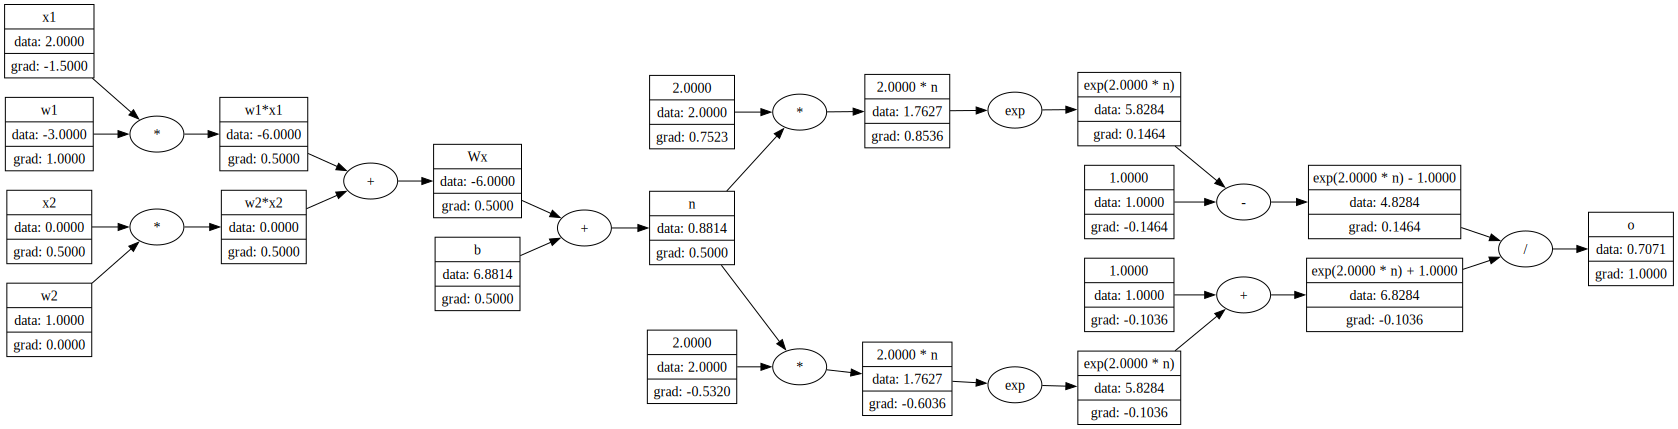

In [395]:
# Single neuron example w/ explicit auto-differentiation for tanh

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1. label = 'w1*x1'
x2w2 = x2*w2; x2w2.label = 'w2*x2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'Wx'
n = x1w1x2w2 + b; n.label = 'n'
o = ((2 * n).exp() - 1) / ((2 * n).exp() + 1); o.label = 'o'  # o = n.tanh()

o.zero_grad()
o.backward()
draw_dot(o)